In [1]:
import sys  
sys.path.insert(1, '../')
# from utils.dataset_utils import OriginalDataset

In [2]:
import os
from utils.dataset_utils import read_img, get_storage
from torchvision.datasets import VisionDataset
import numpy as np

def norm_value(s):
    # return (s + 255.0) / 510.0
    return s / 255.0

def denorm_value(s):
    # return (s * 510.0) - 255.0
    return s * 255.0

class OriginalDataset(VisionDataset):
    def __init__(self, data_path: str, color: bool=True):
        super(OriginalDataset, self).__init__()
        self.data_path = data_path
        self.color = color

    def __getitem__(self, idx: int):
        """
        this dataset returns the image corresponding to the index
        """

        if idx >= len(self) or idx < 0:
            # needed for iterator stop condition
            raise IndexError
        # the img_file_path existence check
        img_path = f'{self.data_path}/idx_{idx}.png'
        img2_path = f'{self.data_path}/idx_{idx+1}.png'
        assert os.path.exists(img_path), f"Invalid img_path: {img_path} in {self.data_path}"
        img1 = read_img(img_path, self.color)
        img2 = read_img(img2_path, self.color)
        img1 = np.array(img1, dtype = np.float32)
        img2 = np.array(img2, dtype = np.float32)
        return norm_value(img2 - img1)

    def __len__(self) -> int:
        dirpath, dir_names, files = next(os.walk(self.data_path))
        return len([i for i in files if "resize" not in i]) - 1

    def __str__(self):
        return f"OriginalDataset({self.data_path})"

    def get_storage_size(self, num_images):
        "returns the total storage size of the dataset"
        total_storage = 0
        for data in [self[i] for i in range(num_images)]:
            total_storage += get_storage(data)
        return total_storage

In [3]:
original_dataset = OriginalDataset('../datasets/droid_100_sample_pictures')
len_ = (original_dataset.__len__())
print(len_)

165


In [4]:
original_dataset[0].shape

(180, 320, 3)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            # nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=1),
            # nn.ReLU(True),
            # nn.Conv2d(16, 32, kernel_size=7, stride=2, padding=1),
            # nn.ReLU(True),
            # nn.Conv2d(32, 32, kernel_size=11),
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=7)
            # nn.ReLU(True),
            # nn.Conv2d(32, 16, kernel_size=7),
            # nn.ReLU(True),
            # nn.Conv2d(16, 8, kernel_size=5)
        )
        
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(8, 16, kernel_size=5),
            # nn.ReLU(True),
            # nn.ConvTranspose2d(16, 32, kernel_size=7),
            # nn.ReLU(True),
            # nn.ConvTranspose2d(32, 32, kernel_size=11),
            # nn.ReLU(True),
            # nn.ConvTranspose2d(32, 16, kernel_size=7, stride=2, padding=1),
            # nn.ReLU(True),
            # nn.ConvTranspose2d(16, 3, kernel_size=5, stride=2, padding=1),

            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.Sigmoid()
        )
        
    def forward(self, x):
        # x = x / 255.0
        x = self.encoder(x)
        x = self.decoder(x)
        # x = x * 255.0
        # x = x.clamp(-255, 255)
        return x
    
    def test(self, x):
        x = self.encoder(x)
        print(x.size())
        x = self.decoder(x)
        # x = x * 255.0
        # x = x.clamp(-255, 255)
        return x


train_loader = torch.utils.data.DataLoader(original_dataset, batch_size=4, shuffle=True)

model = CNNAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    loss_epoch = 0
    for data in train_loader:
        img = data.permute(0, 3, 1, 2)
        output = model(img)
        # print(output.size(), img.size())
        loss = criterion(output, img)
        loss_epoch += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1:>2}/{num_epochs}], Loss: {loss_epoch/len(train_loader):.6f}')

print("Finish")


Epoch [ 1/20], Loss: 0.005652
Epoch [ 2/20], Loss: 0.001228
Epoch [ 3/20], Loss: 0.000955
Epoch [ 4/20], Loss: 0.000836
Epoch [ 5/20], Loss: 0.000756
Epoch [ 6/20], Loss: 0.000652
Epoch [ 7/20], Loss: 0.000570
Epoch [ 8/20], Loss: 0.000474
Epoch [ 9/20], Loss: 0.000426
Epoch [10/20], Loss: 0.000377
Epoch [11/20], Loss: 0.000347
Epoch [12/20], Loss: 0.000317
Epoch [13/20], Loss: 0.000312
Epoch [14/20], Loss: 0.000285
Epoch [15/20], Loss: 0.000280
Epoch [16/20], Loss: 0.000259
Epoch [17/20], Loss: 0.000244
Epoch [18/20], Loss: 0.000227
Epoch [19/20], Loss: 0.000215
Epoch [20/20], Loss: 0.000206
Finish


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 64, 39, 74])
tensor([-6.,  2.,  2.])
tensor([ 0.2203,  1.5184, -0.5237])


(-0.5, 319.5, 179.5, -0.5)

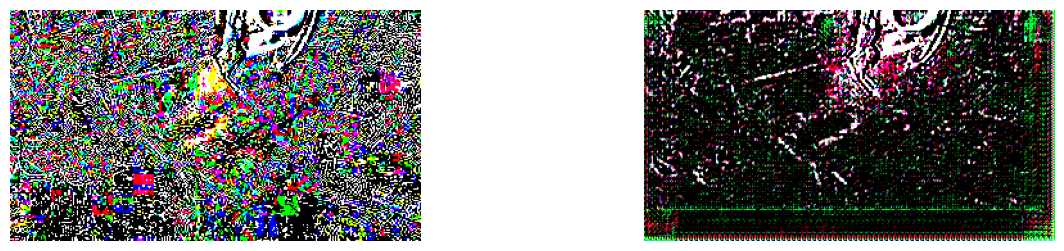

In [14]:
import matplotlib.pyplot as plt
test_image = next(iter(train_loader))[:1]
with torch.no_grad():
    reconstructed = model.test(test_image.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

print(denorm_value(test_image[0][0][0]))
print(denorm_value(reconstructed[0][0][0]))
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
axes[0].imshow(denorm_value(test_image.squeeze()))
axes[0].axis('off')
axes[1].imshow(denorm_value(reconstructed.squeeze()))
axes[1].axis('off')